In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/zap20201028/wrangled_data2.csv


In [2]:
#import seaborn as sns
#!pip install --upgrade seaborn
#sns.__version__

# Modelagem
Agora, com nossos dados já tratados, seguiremos para a modelagem.

Nesse arquivo, treinaremos nosso modelo para fazer a regressão do valor de venda do imóvel. Utilizaremos o algoritmo XGBoost, que é uma implementação otimizada de Gradient Boosting. O Gradient Boosting é um algoritmo de ensemble no qual treinamos classificadores de forma sequencial, em que cada classificador tenta corrigir os erros dos anteriores por meio da modalagem dos resíduos deixados por eles.

* Utilizamos a técnica de otimização bayesiana para fazer o refinamento dos hiperparâmetros do xgboost.
* O modelo final alcançou um erro absoluto médio de R\\$ 151.812,00 no conjunto de teste (pontos nunca vistos pelo modelo).

In [3]:
import pandas as pd
from xgboost import XGBRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

In [4]:
df = pd.read_csv('../input/zap20201028/wrangled_data2.csv')
df

,Street,Area,Dorms,Baths,Parking Slots,Condominio,IPTU,Price
0,Barão de Icaraí,160.0,2,3,2,1200.0,433.0,1800000.0
1,Barão de Icaraí,100.0,2,1,2,950.0,280.0,1050000.0
2,Barão de Icaraí,78.0,2,2,1,790.0,2202.0,949999.0
3,Barão de Icaraí,102.0,3,2,1,1100.0,214.0,973000.0
4,Barão de Icaraí,130.0,3,2,1,1650.0,295.0,1150000.0
...,...,...,...,...,...,...,...,...
1750,Senador Vergueiro,385.0,5,3,1,3680.0,8787.0,2450000.0
1751,Senador Vergueiro,385.0,5,3,1,3680.0,878.0,2500000.0
1752,Senador Vergueiro,198.0,4,4,1,1600.0,491.0,1800000.0
1753,Senador Vergueiro,160.0,3,3,1,1500.0,3840.0,2030000.0


## Preprocessamento das features
Antes do treinamento, faremos um preprocessamento final das features. Vamos transformar as features categórias em dummies.

In [5]:
df_dummies = pd.concat([pd.get_dummies(df.Street), df.drop('Street', axis=1)], axis=1)
df_dummies

,Barão de Icaraí,Cruz Lima,Fernando Osório,Honório de Barros,Marquês de Abrantes,Marquês de Paraná,Oswaldo Cruz,Princesa Januaria,Rui Barbosa,Senador Euzebio,Senador Vergueiro,Area,Dorms,Baths,Parking Slots,Condominio,IPTU,Price
0,1,0,0,0,0,0,0,0,0,0,0,160.0,2,3,2,1200.0,433.0,1800000.0
1,1,0,0,0,0,0,0,0,0,0,0,100.0,2,1,2,950.0,280.0,1050000.0
2,1,0,0,0,0,0,0,0,0,0,0,78.0,2,2,1,790.0,2202.0,949999.0
3,1,0,0,0,0,0,0,0,0,0,0,102.0,3,2,1,1100.0,214.0,973000.0
4,1,0,0,0,0,0,0,0,0,0,0,130.0,3,2,1,1650.0,295.0,1150000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1750,0,0,0,0,0,0,0,0,0,0,1,385.0,5,3,1,3680.0,8787.0,2450000.0
1751,0,0,0,0,0,0,0,0,0,0,1,385.0,5,3,1,3680.0,878.0,2500000.0
1752,0,0,0,0,0,0,0,0,0,0,1,198.0,4,4,1,1600.0,491.0,1800000.0
1753,0,0,0,0,0,0,0,0,0,0,1,160.0,3,3,1,1500.0,3840.0,2030000.0


In [6]:
df_dummies.isna().sum()

Barão de Icaraí          0
Cruz Lima                0
Fernando Osório          0
Honório de Barros        0
Marquês de Abrantes      0
Marquês de Paraná        0
Oswaldo Cruz             0
Princesa Januaria        0
Rui Barbosa              0
Senador Euzebio          0
Senador Vergueiro        0
Area                     0
Dorms                    0
Baths                    0
Parking Slots            0
Condominio               0
IPTU                   145
Price                    0
dtype: int64

In [7]:
X = df_dummies.drop('Price', axis=1)
y = df_dummies.Price
X.head(3)

,Barão de Icaraí,Cruz Lima,Fernando Osório,Honório de Barros,Marquês de Abrantes,Marquês de Paraná,Oswaldo Cruz,Princesa Januaria,Rui Barbosa,Senador Euzebio,Senador Vergueiro,Area,Dorms,Baths,Parking Slots,Condominio,IPTU
0,1,0,0,0,0,0,0,0,0,0,0,160.0,2,3,2,1200.0,433.0
1,1,0,0,0,0,0,0,0,0,0,0,100.0,2,1,2,950.0,280.0
2,1,0,0,0,0,0,0,0,0,0,0,78.0,2,2,1,790.0,2202.0


## Train Test Split
Nossos dados já estão no formato apropriado para serem inputados no modelo.

Antes do treinamento, precisamos separar nosso conjunto de dados em conjunto de treinamento e teste. Faremos um split de 70/30%, respectivamente.

Para fazer a comparação entre diferentes modelos e refinar os hiperparâmetros, não utilizaremos um conjunto de validação dedicado, mas sim a técnica de K-fold cross validation. Assim, não estaremos diminuindo ainda mais o tamanho de nosso conjunto de treinamento, que possui apenas 1228 exemplos. 

O conjunto de teste será usado uma única vez, ao final do projeto, para estimar a performance de nosso modelo em exemplos nunca vistos por ele.

In [8]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# formato apropriado dos dados para xgboost
Dmatrix_train = xgb.DMatrix(data=X_train,label=y_train)

Distribuição de Preços de imóvei no conjunto de teste (laranja) e de treinamento (azul). Perceba que a distribuição é aproximadamente a mesma, como desejado. Do contrário, estaríamos otimizando o modelo para uma distribuição diferente daquela que estamos interessados em acertar.

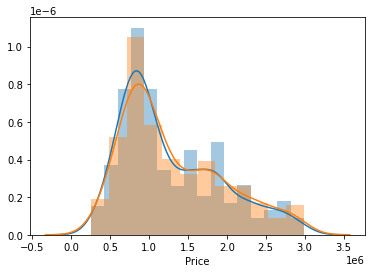

In [9]:
sns.distplot(y_train)
sns.distplot(y_test)

plt.show()

## Benchmark model
Vamos treinar um modelo com os parâmetros default do XGBoost para termos uma base de performance.

Escolhi usar a métrica do erro absoluto médio (MAE) para avaliar a performance do modelo. Isso porque não desejo punir o algoritmo mais intensamente por resíduos maiores, como seria o caso do RMSE.

In [10]:
benchmark_model = XGBRegressor()
benchmark_model = benchmark_model.fit(X_train, y_train)

Resultado XGBoost
MAE: 155623.5784511385
RMSE: 225648.09661769634


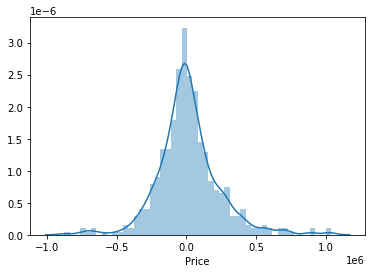

In [11]:
#avaliando métricas do modelo
predictions = benchmark_model.predict(X_test)

print('Resultado XGBoost')
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

sns.distplot((y_test-predictions),bins=50)
plt.show()

Nosso modelo de benchmark apresentou um MAE de R\\$ 155.623 no conjunto de teste. A seguir, refinaremos os hiperparâmetros para diminuir esse valor.

Notamos também que os resíduos são aproximadamente normalmente distribuídos. Fico satisfeito com isso, pois o modelo não é tendencioso em prever valores sempre maiores, ou sempre menores, em comparação com os valores verdadeiros.

## Refinando o modelo
Agora que já treinamos nosso modelo de benchmark, vamos procurar os valores dos hiperparâmetros do xgboost que otimizam nossa métrica de avaliação, o MAE.

A implementação do Gradient Boosting do XGBoosting possui vários parâmetros de treinamento, como por exemplo o learning_rate (coeficiente do resultado encontrado por cada árvore para o cálculo da previsão final) e max_depth (número máximo de camadas de cada árvore, que restringe a quantidade de splits que cada árvore faz). Esses parâmetros não são treináveis, i.e., devem ser informados manualmente ao algoritmo antes que ele realize o treinamento que irá determinar as especificações do modelo que fará a previsão de novos exemplos. Por isso, eles são chamados de hiperparâmetros.

O processo de refinamento consiste em treinar diferentes modelos, que diferem pelos seus hiperparâmetros, e utilizar o conjunto de validação para verificar qual dos modelos faz a melhor previsão. Utilizaremos a técnica de k-fold cross validation, que separa nosso training set em k subconjuntos, treina o algoritmo em (k-1) desses subconjuntos e usa o subconjunto que ficou de fora para avaliar nossa métrica de avaliação, o MAE. Isso é repetido k vezes, cada vez com um subconjunto diferente de fora do treinamento. Ao final, fazemos a média dos k MAE medidos.

As duas formas mais comuns de se testar diferentes conjuntos de hiperparâmetros são o "grid search" e o "random search". No primeiro, definimos um conjunto discreto de valores candidatos para cada hiperparâmetro, e treinamos modelos com todas as combinações possíveis entre os diferentes hiperparâmetros. No segundo, definimos intervalos de valores candidatos para cada hiperparâmetro, e selecionamos aleatoriamente, dentro de cada intervalo, os valores que serão utilizados em cada modelo.

Uma terceira forma de fazer a busca por hiperparâmetros é o [Bayesian optimization](https://towardsdatascience.com/automated-machine-learning-hyperparameter-tuning-in-python-dfda59b72f8a). Nesse método, também sorteamos aleatoriamente valores para os hiperparâmetros. Mas, ao contrário do random search, onde a distribuição de probabilidades entre os valores possíveis é uniforme, o Bayesian optimization utiliza iterativamente os resultados que vão sendo obtidos para explorar mais intensamente os intervalos de valores mais promissores, para cada hiperparâmetro. Assim, a cada novo modelo treinado, é atualizada a distribuição de probabilidade dos valores associados a cada hiperparâmetro. A implementação do Bayesian optimization que utilizaremos aqui é a do pacote [hyperopt](https://github.com/hyperopt/hyperopt).

In [12]:
from hyperopt import hp

#Espaço de hiperparâmetros a ser explorado:
space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.6)),
    'gamma': hp.uniform('gamma', 0.0, 5.0),
    'max_depth': hp.randint('max_depth', 4, 30),
    'min_child_weight': hp.loguniform('min_child_weight', np.log(0.08), np.log(10)),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 2.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
}

In [13]:
#Testando o espaço de hiperparâmetros: sorteando um conjunto aleatório de hiperparâmetros
from hyperopt.pyll.stochastic import sample

example = sample(space)
example

{'gamma': 2.0678427597526827,
 'learning_rate': 0.4353827753259679,
 'max_depth': array(6),
 'min_child_weight': 6.420824530285674,
 'reg_alpha': 1.4525003372482628,
 'reg_lambda': 0.18656780304151166}

In [14]:
from hyperopt import STATUS_OK

#definindo a função que treina o modelo e calcula a métrica de avaliação (usando k-fold cv)
def objective(params):
    """Objective function for Gradient Boosting Machine Hyperparameter Tuning"""     
    
    #gerando o modelo
    #model = XGBRegressor()
    
    #treinando o modelo
    cv_results = xgb.cv(dtrain=Dmatrix_train, params=params, nfold=10,
                    num_boost_round=1000,early_stopping_rounds=25, metrics="mae", as_pandas=False, seed=101)
    
    #métrica de avaliação: 1 - ROC AUC
    loss = cv_results['test-mae-mean'][-1]
    
    # dicionário com o resultado
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [15]:
# Fazendo 500 iterações da busca bayesiana

# Algoritmo
from hyperopt import tpe
tpe_algorithm = tpe.suggest


# Objeto que registra o progresso
from hyperopt import Trials
bayes_trials = Trials()

# Função que faz a busca
from hyperopt import fmin

# Rodando a busca
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = 500, trials = bayes_trials)

100%|██████████| 500/500 [57:37<00:00,  6.92s/trial, best loss: 137713.2320312]


In [16]:
# hiperparâmetros do melhor modelo
best

{'gamma': 4.99838244542053,
 'learning_rate': 0.03912246776120425,
 'max_depth': 29,
 'min_child_weight': 3.485648967260897,
 'reg_alpha': 1.3681590662840368,
 'reg_lambda': 0.4344152151420315}

In [17]:
#infos do melhor modelo
bayes_trials.best_trial['result']#['params']

{'loss': 137713.2320312,
 'params': {'gamma': 4.99838244542053,
  'learning_rate': 0.03912246776120425,
  'max_depth': 29,
  'min_child_weight': 3.485648967260897,
  'reg_alpha': 1.3681590662840368,
  'reg_lambda': 0.4344152151420315},
 'status': 'ok'}

In [18]:
#guardando os hyperparâmetros do melhor modelo
#params = bayes_trials.best_trial['result']['params']
params = {'gamma': 2.199596107711117,
  'learning_rate': 0.0974381627092206,
  'max_depth': 29,
  'min_child_weight': 3.2385338264269485,
  'reg_alpha': 0.18472575899500998,
  'reg_lambda': 0.38244758223682157}

In [19]:
# verificando qual é o n_estimators ótimo para o melhor modelo
cv_results = xgb.cv(dtrain=Dmatrix_train, params=params, nfold=10,
                    num_boost_round=1000,early_stopping_rounds=25, metrics="mae", as_pandas=True, seed=101)

#best score
cv_results.tail(2)

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
56,22292.634766,391.822739,137941.603125,9270.245457
57,21604.397852,394.904582,137915.209375,9268.285447


In [20]:
# treinando o melhor modelo
final_model = XGBRegressor(
        n_estimators=58,
        learning_rate = params['learning_rate'],
        gamma = params['gamma'],
        max_depth = params['max_depth'],
        min_child_weight = params['min_child_weight'],
        reg_lambda = params['reg_lambda'],
        reg_alpha = params['reg_alpha'],
    )

final_model = final_model.fit(X_train, y_train)

Resultado XGBoost
MAE: 21563.60172791124
RMSE: 36916.73842820076


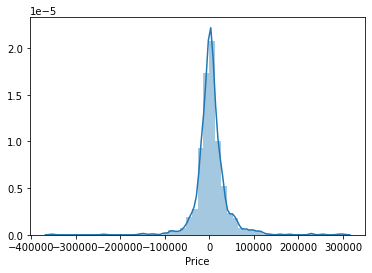

In [21]:
#avaliando métricas do melhor modelo no conjunto de TREINAMENTO
predictions = final_model.predict(X_train)

print('Resultado XGBoost')
print('MAE:', metrics.mean_absolute_error(y_train, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, predictions)))

sns.distplot((y_train-predictions),bins=50)
plt.show()

Resultado XGBoost
MAE: 152613.1968690702
RMSE: 224883.2077147728


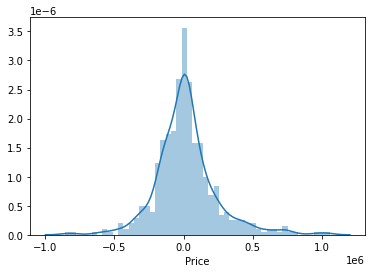

In [22]:
#avaliando métricas do melhor modelo no conjunto de TESTE
predictions = final_model.predict(X_test)

print('Resultado XGBoost')
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

sns.distplot((y_test-predictions),bins=50)
plt.show()

A busca bayesiana permitiu que refinássemos os hiperparâmetros, diminuindo o MAE de ___ (modelo de benchmark) para ___, no conjunto de teste.

### Avaliando overfitting
No conjunto de treinamento, obtivemos um MAE de cerca de R\\$ 22mil, enquanto que no conjunto de teste o MAE foi de cerca de R\\$ 150mil. Isso mostra que nosso modelo apresenta um grau de overfitting relativamente elevado. Ele está prevendo muito bem pontos do conjunto de treinamento, mas não está generalizando tão bem para pontos nunca vistos por ele no treinamento.

Para minimizar o overfitting podemos otimizar certos hiperparâmetros do XGBoosting com que ainda não trabalhamos, como o subsample. Outra estratégia para combater o problema é aumentar o tamanho de nosso conjunto de treinamento.

Numa próxima etapa do projeto tentaremos minimizar esse overfitting. 

# Previsão para nosso cliente
Com o modelo final já treinado, podemos fazer a previsão do valor de venda do imóvel de nosso cliente.

O imóvel fica localizado na Avenida Oswaldo Cruz. Possui 102m², 4 quartos, 3 banheiros e 1 vaga de garagem. O condomínio é de R\\$ 2000, e o IPTU de R\\$ 250. Assim, nossas features assumem os seguintes valores:

In [23]:
client_info = pd.Series([0,0,0,0,0,0,1,0,0,0,0,102, 4, 3, 1, 2000, 250], index=df_dummies.columns[:-1])

x = pd.DataFrame(client_info).transpose()
x

,Barão de Icaraí,Cruz Lima,Fernando Osório,Honório de Barros,Marquês de Abrantes,Marquês de Paraná,Oswaldo Cruz,Princesa Januaria,Rui Barbosa,Senador Euzebio,Senador Vergueiro,Area,Dorms,Baths,Parking Slots,Condominio,IPTU
0,0,0,0,0,0,0,1,0,0,0,0,102,4,3,1,2000,250


In [24]:
#fazendo a previsão para o apartamento de nosso cliente

prediction = final_model.predict(x)

print(f"A previsão é de R$ {prediction[0]}")

A previsão é de R$ 1183819.75


Vemos acima que a previsão de valor para o imóvel de nosso cliente é de R\\$ 1.183.002,00.

É importante lembrar que esse valor foi encontrado com base nos valores dos anúncios de outros imóveis da região. É muito comum que sejam negociados descontos sobre os valores anunciados. Logo, não necessariamente o valor encontrado por nosso modelo é o valor de mercado real do imóvel.

Vale salientar também que nosso modelo não incorporou características dos imóveis que são relevantes para os preços de venda, como estado de conservação do edifício e do imóvel, além da vista.

# Explicabilidade do modelo
Com o modelo já treinado e otimizado, agora nossa tarefa é entender e explicar quais são as decisões que o modelo toma para chegar a determinada previsão de valor.

Usaremos o SHAP (SHapley Additive exPlanations), que é um approach baseado em teoria dos jogos para cumprir essa tarefa. Usaremos a implementação da biblioteca [shap](https://github.com/slundberg/shap) para Python.

Primeiramente, vamos carregar a biblioteca, e encontrar os valores de shap para os exemplos de nosso conjunto de treinamento.

In [25]:
import shap

#calculando os valores de SHAP para cada feature de cada reserva
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_train)

Existe uma relação monotonamente crescente entre a soma dos valores de SHAP para todas as features de um imóvel, e a previsão que nosso model faz para o valor desse imóvel. Isso significa que quanto maior for o valor total de SHAP para um imóvel, maior é o valor de venda, previsto por nosso modelo. Em outras palavras, reservas que tem um valor total de SHAP alto também têm altos valores de venda. E reservas com valor total de SHAP baixo têm baixos valores de venda. O SHAP de uma certa feature, para um certo imóvel, informa a contribuição marginal que aquela feature tem na previsão de valor de venda.

## Medindo Feature importances pelo SHAP
Como valores de SHAP altos aumentam a previsão de valor de venda, e valores de SHAP baixos diminuem essa previsão, então a média dos módulos dos valores de SHAP para uma certa feature, ao longo de todo o nosso dataset, dá uma ideia de quão importante aquela feature é para que nosso modelo faça sua previsão.

Essas importâncias relativas são mostradas no gráfico abaixo. Notamos que a área é, disparada, a feature mais importante para que nosso modelo faça a previsão de valor de venda de imóvel. Com muito menos importância, mas ainda sim importantes, temos o número de vagas de garagem. Em seguida, com igual importância, temos o valor de condomínio, IPTU, e o fato do imóvel estar (ou não) localizado na Avenida Rui Barbosa. A seguir, com um pouco menos importância, temos o número de banheiros e de dormitórios. As outras features informam se o imóvel está localizado em cada uma das ruas estudadas.

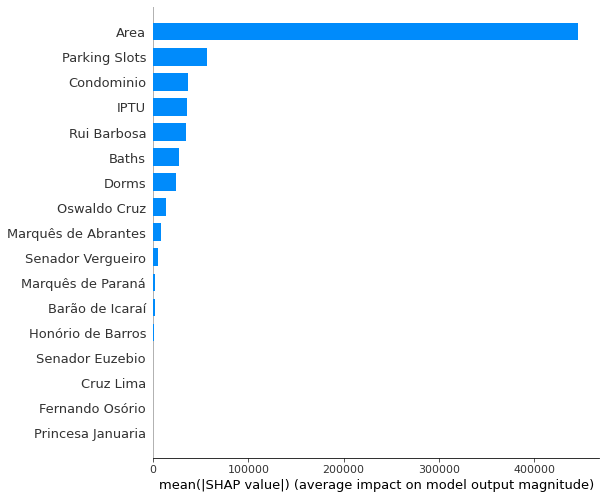

In [26]:
#plotando as feature importances finais
shap.summary_plot(shap_values, X_train.columns, plot_type="bar")

## Impacto das features na previsão do modelo
O gráfico abaixo dá uma visão geral das decisões que nosso modelo faz para chegar à previsão de valor de venda do imóvel. Cada linha representa uma feature diferente e deve ser lida separadamente. Perceba que as features são ordenadas da mais importante para a menos importante, de acordo com as feature importances mostradas acima.

A primeira linha representa a área do imóvel. Temos uma correlação positiva: quanto maior é a área do imóvel, maior é a previsão de valor de venda encontrada por nosso modelo.

A segunda linha representa quantas vagas de garagem possui o imóvel. Quando não há vagas (em azul), a previsão de valor é diminuída. Quando há 1 vaga (cluster roxo), a previsão é suavemente aumentada. Para mais vagas, temos maiores aumentos na previsão do modelo.

A terceira e quarta linhas, de Condomínio e IPTU, respectivamente, apresentam comportamentos similares. Quando esses valores são mais baixos, a previsão do modelo tende a diminuir.

A quinta linha, Rui Barbosa, mostra que nosso modelo atribui um valor premium a imóveis localizados nessa rua. Imóveis que não estão localizados na Rui Barbosa sofrem uma diminuição de previsão de nota, e imóveis que lá estão têm sua previsão aumentada.

As linhas seis e sete mostram que a tendência é que a previsão de nota sejam maior quando o imóvel possui mais banheiros ou quartos, mas esse efeito é limitado.

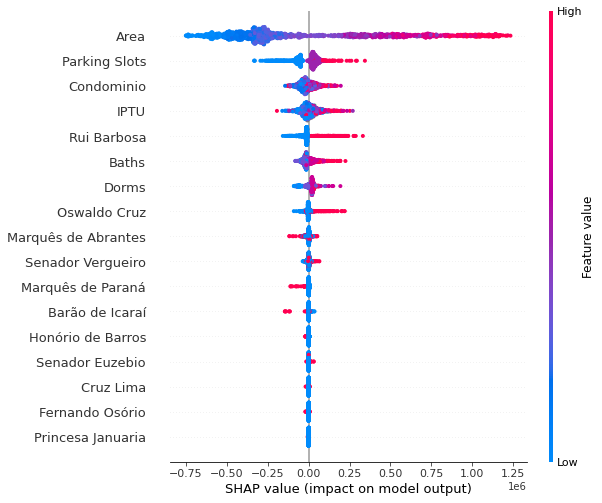

In [27]:
#plotando os valores de SHAP para cada feature de cada reserva
shap.summary_plot(shap_values, X_train)

### Area
O gráfico abaixo mostra que a previsão do modelo tem relação aproximadamente linear com a área do imóvel, em especial para imóveis com áreas de até 140m².

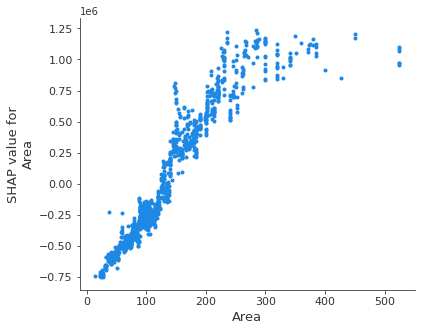

In [28]:
shap.dependence_plot('Area', shap_values, X_train, interaction_index=None)

## Vagas de Garagem
O gráfico abaixo reafirma que imóveis com vagas de garagem tendem a ter maiores previsões de valor feitas por nosso modelo.

Podemos observar um outro efeito interessante: caso o imóvel não possua vagas de garagem, a diminuição na previsão que nosso modelo faz é mais intensa para imóveis de maior área.

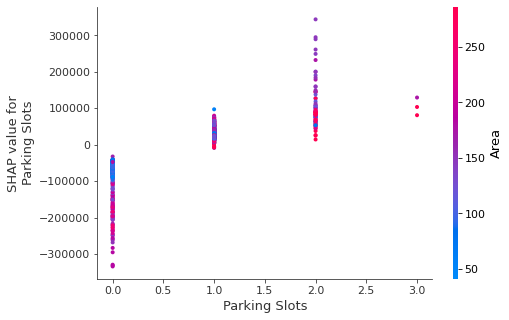

In [29]:
shap.dependence_plot('Parking Slots', shap_values, X_train, interaction_index="Area")

## Condomínio
Valores baixos de condomínio tendem a fazer a previsão do nosso modelo diminuir.

Em contrapartida, valores altos de condomínio não geram um aumento ou diminuição consistente de previsão do modelo.

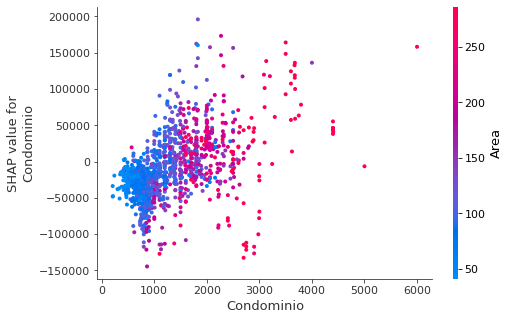

In [30]:
shap.dependence_plot('Condominio', shap_values, X_train, interaction_index="Area")

## Rui Barbosa
Nosso modelo associa um valor premium a apartamentos que estão localizados na Av. Rui Barbosa.

O gráfico abaixo mostra um efeito interessante: apartamentos com grandes áreas sofrem uma penalização maior na previsão de nosso modelo por não estarem localizados na Rui Barbosa, se comparados a imóveis de menores áreas.

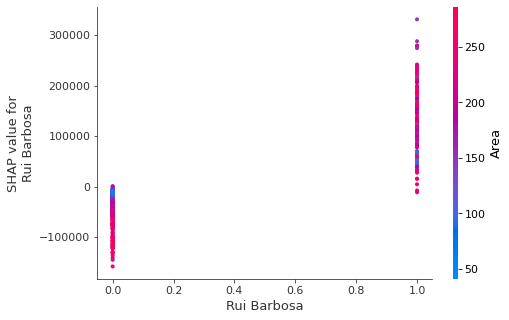

In [31]:
shap.dependence_plot('Rui Barbosa', shap_values, X_train)

## Banheiros
Quanto maior o número de banheiros, maior a previsão de nosso modelo. Outro efeito interessante mostrado abaixo é que quando um imóvel possui 3 ou 4 banheiros, o aumento da previsão do modelo é mais intenso para imóveis de menor área. Em outras palavras, esses imóveis "compensam" sua menor área pela presença de um banheiro extra.

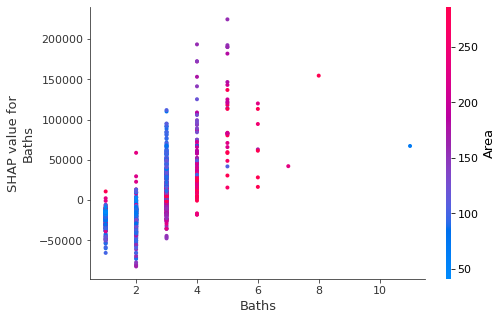

In [32]:
shap.dependence_plot('Baths', shap_values, X_train, interaction_index="Area")

## Quartos
vemos abaixo que nosso modelo diminui fortemente a previsão de valor de imóveis que possuem apenas um quarto.

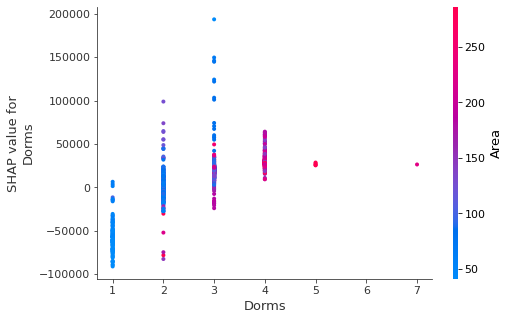

In [33]:
shap.dependence_plot('Dorms', shap_values, X_train, interaction_index="Area")

## Oswaldo Cruz
Vemos abaixo que o modelo aumenta a previsão de nota quando o imóvel está localizado na Av. Oswaldo Cruz.

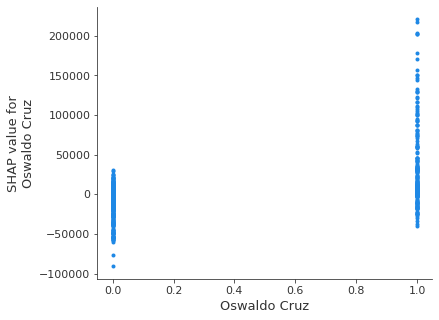

In [34]:
shap.dependence_plot('Oswaldo Cruz', shap_values, X_train, interaction_index=None)